# Feature engineering experiments

## Objective
Systematically test engineered features to improve CRV veto discrimination.

**Base run:** `d`

More complete feature set.

## Strategy
1. Load baseline training data
2. Create candidate engineered features
3. Test feature importance systematically
4. Compare performance metrics

## Setup

In [1]:
# System tools  
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Python stack 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# ML tools
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

# Internal modules 
sys.path.extend(["../../../src/core", "../../../src/utils"])
from io_manager import Load

# pyutils 
from pyutils.pyplot import Plot
plotter = Plot()

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## Load data

In [2]:
run = "d"
base_in_path = Path(f"../../../output/ml/veto/{run}/data/")

cry_data = Load(in_path=base_in_path / "CRY_onspill-LH_aw").load_pkl()
ce_mix_data = Load(in_path=base_in_path / "CE_mix_onspill-LH_aw").load_pkl()

print(f"✓ Loaded CRY: {len(cry_data['events'])} events")
print(f"✓ Loaded CE mix: {len(ce_mix_data['events'])} events")

[Load] ✅ Initialised with out_path=../../../output/ml/veto/d/data/CRY_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../../output/ml/veto/d/data/CRY_onspill-LH_aw/results.pkl
[Load] ✅ Initialised with out_path=../../../output/ml/veto/d/data/CE_mix_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../../output/ml/veto/d/data/CE_mix_onspill-LH_aw/results.pkl
✓ Loaded CRY: 20081 events
✓ Loaded CE mix: 428440 events


## Create engineered features

Test physics-motivated combinations

In [3]:
def engineer_features(events_dict):
    """Create engineered features from raw data"""
    df = ak.to_dataframe(events_dict)
    
    # Store original features
    features = {}
    for col in ['crv_z', 'crv_y', 'crv_x', 'angle', 'nLayers', 'PEs', 'nHits', 'dT', 't0', 'd0', 'tanDip', 'maxr']:
        features[col] = df[col].values
    
    return pd.DataFrame(features)

# Create feature sets for both samples
df_CRY = engineer_features(cry_data["events"])
df_CE_mix = engineer_features(ce_mix_data["events"])

# Add labels
df_CRY["label"] = 1  # CRY = signal
df_CE_mix["label"] = 0  # CE mix = background

print(f"Added {len(df_CRY.columns)-1} features")

Added 12 features


## Feature comparison function

In [4]:
def test_feature_set(feature_list, df_cry, df_ce, run_name="test"):
    """Train model with given feature set and return metrics"""
    
    # Combine datasets
    df_train = pd.concat([df_cry, df_ce], ignore_index=True)
    df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Select features
    X = df_train[feature_list]
    y = df_train["label"]
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    )
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    test_pred = model.predict_proba(X_test_scaled)[:, 1]
    test_auc = roc_auc_score(y_test, test_pred)
    
    # Feature importance
    importance = dict(zip(feature_list, model.feature_importances_))
    
    return {
        'name': run_name,
        'features': feature_list,
        'n_features': len(feature_list),
        'test_auc': test_auc,
        'importance': importance,
        'model': model
    }

In [5]:
df_CRY

,crv_z,crv_y,crv_x,angle,nLayers,PEs,nHits,dT,t0,d0,tanDip,maxr,label
0,-6253.561523,2705.412109,-1004.319641,-0.346188,4,749.809937,16,53.863532,993.879218,30.339418,0.853899,602.004883,1
1,-4452.555664,2707.043701,-263.125854,-0.262909,4,612.518982,19,34.975695,1594.740710,56.110069,0.672509,670.045837,1
2,2413.186279,2707.886475,-531.959473,0.325753,4,769.735168,16,96.972347,823.701229,98.309525,0.715108,673.439026,1
3,-5361.167480,1422.602783,-2581.572266,0.220560,4,620.438416,16,39.114965,1052.470739,21.650793,0.732891,497.028534,1
4,-6507.955566,2703.311523,-784.564758,-0.325035,4,683.286865,18,51.129243,1236.527559,7.158191,0.923110,493.364136,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20076,-440.758667,2719.546143,-2260.563965,0.994648,4,1903.002930,17,66.726711,1494.490383,34.331017,0.518293,633.064148,1
20077,-3673.013184,2700.181152,-1418.531250,-0.290878,4,805.816040,19,37.388058,1112.916867,68.659538,0.537914,678.746338,1
20078,-4180.637207,2700.142822,-1597.998535,-0.308574,4,757.951050,18,38.899462,1314.947436,6.651045,0.578253,675.076355,1
20079,-4906.522461,1148.963013,-2575.632324,0.319433,4,708.407227,16,38.402736,1478.891261,11.212142,0.729459,668.615051,1


## Test different feature combinations

In [6]:
scenarios = {
    # testing individual features
    'dT': ['dT'],
    'crv_z': ['crv_z'],
    'crv_y': ['crv_y'],
    'crv_x': ['crv_x'],
    'angle': ['angle'],
    'nLayers': ['nLayers'],
    'PEs': ['PEs'],
    'nHits': ['nHits'],
    't0': ['t0'],
    'd0': ['d0'],
    'tanDip': ['tanDip'],
    'maxr': ['maxr'],
}
  

# Run tests
results = []
for name, features in scenarios.items():
    print(f"Testing: {name}")
    result = test_feature_set(features, df_CRY, df_CE_mix, name)
    results.append(result)
    print(f"  → Test AUC: {result['test_auc']:.4f}")
    
print("\n✅ Completed all tests")

Testing: dT
  → Test AUC: 0.9347
Testing: crv_z
  → Test AUC: 0.9347
Testing: crv_z
  → Test AUC: 0.8801
Testing: crv_y
  → Test AUC: 0.8801
Testing: crv_y
  → Test AUC: 0.9183
Testing: crv_x
  → Test AUC: 0.9183
Testing: crv_x
  → Test AUC: 0.9512
Testing: angle
  → Test AUC: 0.9512
Testing: angle
  → Test AUC: 0.8678
Testing: nLayers
  → Test AUC: 0.8678
Testing: nLayers
  → Test AUC: 0.7331
Testing: PEs
  → Test AUC: 0.7331
Testing: PEs
  → Test AUC: 0.9645
Testing: nHits
  → Test AUC: 0.9645
Testing: nHits
  → Test AUC: 0.9566
Testing: t0
  → Test AUC: 0.9566
Testing: t0
  → Test AUC: 0.5794
Testing: d0
  → Test AUC: 0.5794
Testing: d0
  → Test AUC: 0.6072
Testing: tanDip
  → Test AUC: 0.6072
Testing: tanDip
  → Test AUC: 0.7602
Testing: maxr
  → Test AUC: 0.7602
Testing: maxr
  → Test AUC: 0.7430

✅ Completed all tests
  → Test AUC: 0.7430

✅ Completed all tests


## Compare results

In [7]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Scenario': r['name'],
        'N features': r['n_features'],
        'Test AUC': r['test_auc'],
        'Top feature': max(r['importance'], key=r['importance'].get),
        'Top importance': max(r['importance'].values())
    }
    for r in results
])

# Sort by AUC
comparison_df = comparison_df.sort_values('Test AUC', ascending=False)
display(comparison_df)

,Scenario,N features,Test AUC,Top feature,Top importance
6,PEs,1,0.964528,PEs,1.0
7,nHits,1,0.956603,nHits,1.0
3,crv_x,1,0.951230,crv_x,1.0
0,dT,1,0.934749,dT,1.0
2,crv_y,1,0.918338,crv_y,1.0
1,crv_z,1,0.880107,crv_z,1.0
4,angle,1,0.867833,angle,1.0
10,tanDip,1,0.760210,tanDip,1.0
11,maxr,1,0.742966,maxr,1.0
5,nLayers,1,0.733061,nLayers,1.0


	Wrote ../../../output/images/ml/veto/d/xgboost/features/bar_single_features.png


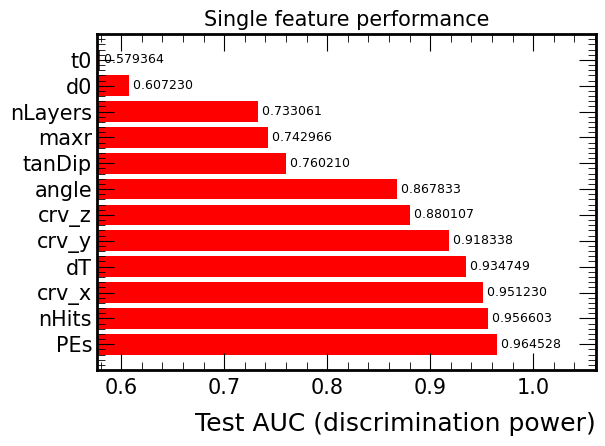

In [8]:
# Plot comparison
fig, ax = plt.subplots(figsize=(6.4, 4.8))

scenarios_sorted = comparison_df['Scenario'].values
aucs = comparison_df['Test AUC'].values

bars = ax.barh(scenarios_sorted, aucs)
ax.set_xlabel('Test AUC (discrimination power)')
ax.set_title('Single feature performance')
ax.set_xlim(min(aucs)*0.995, max(aucs)*1.1)

# Add value labels
for i, (scenario, auc) in enumerate(zip(scenarios_sorted, aucs)):
    ax.text(auc, i, f' {auc:.6f}', va='center', fontsize=9)

plt.tight_layout()

run="d"
img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
img_feature_out_path = img_base_path / "features"
img_feature_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "bar_single_features.png"

plt.savefig(out_name, dpi=300)

print(f"\tWrote {out_name}")

plt.show()


## Test CRV-focused feature set combinations 

In [9]:
# Generate all possible combinations of the 8 features
from itertools import combinations
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm

base_features = ['dT', 'crv_z', 'crv_y', 'crv_x', 'angle', 'nLayers', 'PEs', 'nHits']

scenarios = {}

# Generate all combinations from size 2 to 8
for size in range(2, len(base_features) + 1):
    for combo in combinations(base_features, size):
        name = ' + '.join(combo)
        scenarios[name] = list(combo)

print(f"Generated {len(scenarios)} feature combinations\n")

# Wrapper function for parallel execution
def test_scenario(item):
    name, features = item
    result = test_feature_set(features, df_CRY, df_CE_mix, name)
    return result

# Run tests in parallel
results = []
with ThreadPoolExecutor(max_workers=12) as executor:
    # Submit all tasks
    futures = {executor.submit(test_scenario, item): item for item in scenarios.items()}
    
    # Process completed tasks with progress bar
    for future in tqdm(as_completed(futures), total=len(scenarios), desc="Testing combinations"):
        result = future.result()
        results.append(result)

print("\n✓ Completed all tests")

Generated 247 feature combinations



Generated 247 feature combinations



Testing combinations: 100%|██████████| 247/247 [08:36<00:00,  2.09s/it]


✓ Completed all tests


## Compare results

In [10]:
# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Scenario': r['name'],
        'N features': r['n_features'],
        'Test AUC': r['test_auc'],
        'Top feature': max(r['importance'], key=r['importance'].get),
        'Top importance': max(r['importance'].values())
    }
    for r in results
])

# Sort by AUC
comparison_df = comparison_df.sort_values('Test AUC', ascending=False)
display(comparison_df)

,Scenario,N features,Test AUC,Top feature,Top importance
246,dT + crv_z + crv_y + crv_x + angle + nLayers +...,8,0.999933,crv_z,0.437748
238,dT + crv_z + crv_y + crv_x + angle + PEs + nHits,7,0.999924,crv_z,0.549524
244,dT + crv_z + crv_y + angle + nLayers + PEs + n...,7,0.999920,crv_z,0.433273
226,dT + crv_z + angle + nLayers + PEs + nHits,6,0.999910,crv_z,0.407297
217,dT + crv_z + crv_y + angle + PEs + nHits,6,0.999904,crv_z,0.540241
...,...,...,...,...,...
10,dT + nLayers,2,0.966207,nLayers,0.672199
26,nLayers + PEs,2,0.966107,PEs,0.888518
5,crv_z + crv_y,2,0.965228,crv_z,0.546239
24,nLayers + nHits,2,0.964091,nHits,0.743529


## Plot top 10 

In [12]:
# Get top 10 scenarios
top_10 = comparison_df.head(10)
display(top_10)

,Scenario,N features,Test AUC,Top feature,Top importance
246,dT + crv_z + crv_y + crv_x + angle + nLayers +...,8,0.999933,crv_z,0.437748
238,dT + crv_z + crv_y + crv_x + angle + PEs + nHits,7,0.999924,crv_z,0.549524
244,dT + crv_z + crv_y + angle + nLayers + PEs + n...,7,0.999920,crv_z,0.433273
226,dT + crv_z + angle + nLayers + PEs + nHits,6,0.999910,crv_z,0.407297
217,dT + crv_z + crv_y + angle + PEs + nHits,6,0.999904,crv_z,0.540241
243,dT + crv_z + crv_y + crv_x + nLayers + PEs + n...,7,0.999902,crv_z,0.427421
239,dT + crv_z + crv_x + angle + nLayers + PEs + n...,7,0.999900,crv_z,0.435929
214,dT + crv_z + crv_y + crv_x + PEs + nHits,6,0.999891,crv_z,0.547193
221,dT + crv_z + crv_x + nLayers + PEs + nHits,6,0.999890,crv_z,0.430351
173,dT + crv_z + angle + PEs + nHits,5,0.999888,crv_z,0.504098


	Wrote ../../../output/images/ml/veto/d/xgboost/features/bar_single_features.png


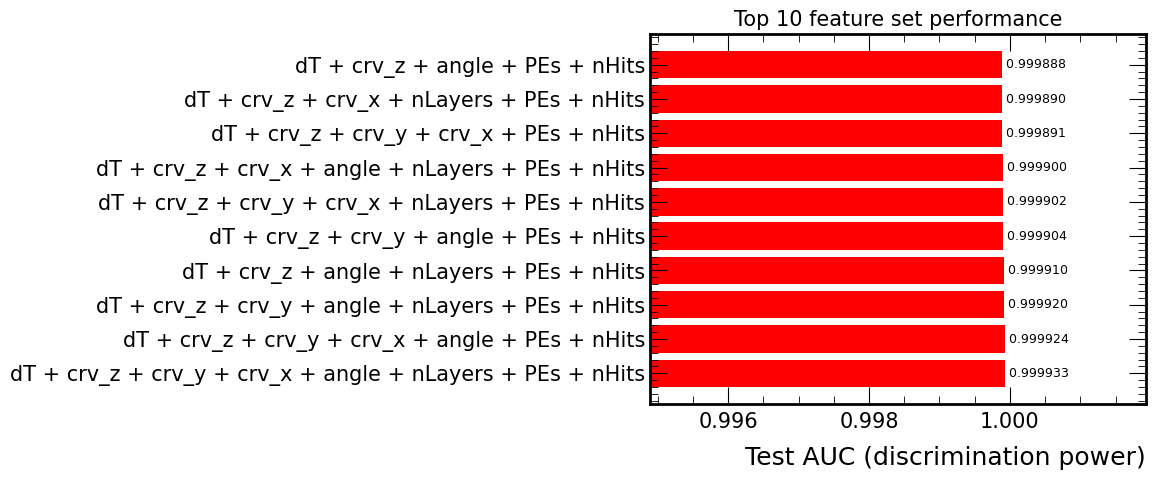

In [22]:
# Plot comparison
fig, ax = plt.subplots(figsize=(6.4, 4.8))

scenarios_sorted = top_10['Scenario'].values
aucs = top_10['Test AUC'].values

bars = ax.barh(scenarios_sorted, aucs)
ax.set_xlabel('Test AUC (discrimination power)')
ax.set_title('Top 10 feature set performance')
ax.set_xlim(min(aucs)*0.995, max(aucs)*1.002)

# Add value labels
for i, (scenario, auc) in enumerate(zip(scenarios_sorted, aucs)):
    ax.text(auc, i, f' {auc:.6f}', va='center', fontsize=9)

plt.tight_layout()

out_name = img_feature_out_path / "bar_single_features.png"

plt.savefig(out_name, dpi=300)

print(f"\tWrote {out_name}")

plt.show()


## Detailed feature importance for best model

Best model: dT + crv_z + crv_y + crv_x + angle + nLayers + PEs + nHits
Test AUC: 0.9999

	Wrote ../../../output/images/ml/veto/d/xgboost/features/bar_best_feature_set_performance.png


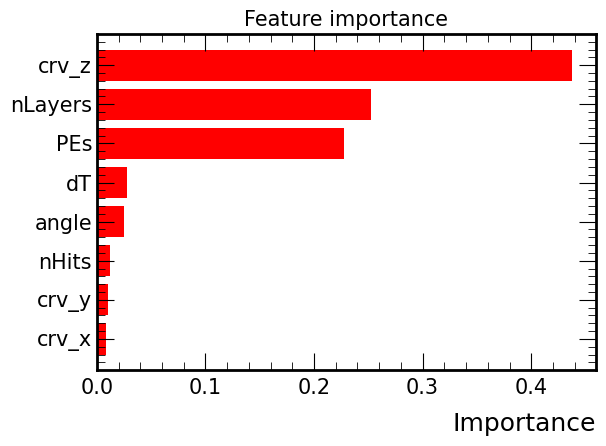

,Feature,Importance
1,crv_z,0.437748
5,nLayers,0.252023
6,PEs,0.227303
0,dT,0.027879
4,angle,0.024834
7,nHits,0.012142
2,crv_y,0.009895
3,crv_x,0.008175


In [26]:
# Get best model
best_result = results[comparison_df.index[0]]

print(f"Best model: {best_result['name']}")
print(f"Test AUC: {best_result['test_auc']:.4f}\n")

# Plot feature importance
importance_df = pd.DataFrame(
    list(best_result['importance'].items()),
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=True)

fig, ax = plt.subplots() # figsize=(8, 6))
ax.barh(importance_df['Feature'], importance_df['Importance'])
ax.set_xlabel('Importance')
ax.set_title(f"Feature importance")
plt.tight_layout()

out_name = img_feature_out_path / "bar_best_feature_set_performance.png"

plt.savefig(out_name, dpi=300)

print(f"\tWrote {out_name}")

plt.show()

# Display importance values
display(importance_df.sort_values('Importance', ascending=False))

## Feature correlation matrix

Check for redundancy between features

,dT,crv_z,crv_y,crv_x,angle,nLayers,PEs,nHits
0,53.863532,-6253.561523,2705.412109,-1004.319641,-0.346188,4,749.809937,16
1,34.975695,-4452.555664,2707.043701,-263.125854,-0.262909,4,612.518982,19
2,96.972347,2413.186279,2707.886475,-531.959473,0.325753,4,769.735168,16
3,39.114965,-5361.167480,1422.602783,-2581.572266,0.220560,4,620.438416,16
4,51.129243,-6507.955566,2703.311523,-784.564758,-0.325035,4,683.286865,18


	Wrote ../../../output/images/ml/veto/d/xgboost/features/h2_feature_correlation_matrix.png


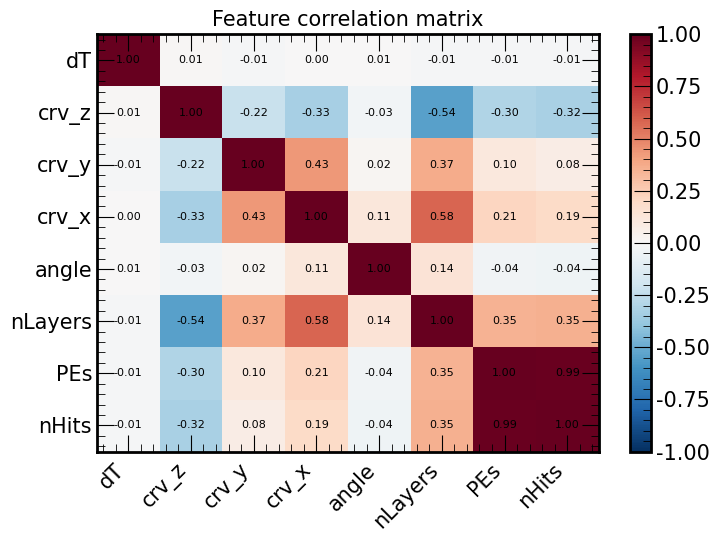


Strong correlations (|r| > 0.7):
  PEs ↔ nHits: 0.989


In [30]:
# Get features for best model
best_features = best_result['features']

# Combine data and compute correlation
df_combined = pd.concat([df_CRY[best_features], df_CE_mix[best_features]], ignore_index=True)

display(df_combined.head())
correlation_matrix = df_combined.corr()

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(1.2*6.4, 1.2*4.8))
im = ax.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

# Set ticks and labels
ax.set_xticks(np.arange(len(best_features)))
ax.set_yticks(np.arange(len(best_features)))
ax.set_xticklabels(best_features, rotation=45, ha='right')
ax.set_yticklabels(best_features)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
# cbar.set_label('Correlation coefficient', rotation=270, labelpad=20)

# Add correlation values
for i in range(len(best_features)):
    for j in range(len(best_features)):
        text = ax.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=8)

ax.set_title(f'Feature correlation matrix') 
plt.tight_layout()


out_name = img_feature_out_path / "h2_feature_correlation_matrix.png"

plt.savefig(out_name, dpi=300)

print(f"\tWrote {out_name}")

plt.show()

# Highlight strong correlations (|r| > 0.7, excluding diagonal)
print("\nStrong correlations (|r| > 0.7):")
for i in range(len(best_features)):
    for j in range(i+1, len(best_features)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            print(f"  {best_features[i]} ↔ {best_features[j]}: {corr_val:.3f}")